# 导入包

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

# 网络

In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样, 直接sample会阻碍计算图梯度更新
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # ! 计算tanh_normal分布的对数概率密度, 没理解为什么这样算
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound  # 缩放到动作空间
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# SAC连续环境

In [3]:
from numpy import ndarray


class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值, 可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)  # 用于控制熵的重要程度
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # ? 目标熵的大小, 这里是-1, 似乎是可调整超参数
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state) -> list:
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        action = [self.actor(state)[0].item()]
        return action

    def calc_target(self, rewards, next_states, dones, truncated):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 熵 = -对数动作概率, 定义如此
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)
        # 和之前章节一样, 对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

# ✅SAC基本思想

SAC的公式推导还没完全理解, 但是基本思路是, 对网络输入状态, 网络给出动作和该动作的对数概率, 而把动作的对数概率取负就是熵, 熵越大, 代表该动作的不确定性越大, 也就是发生概率较小, 反过来, 熵越小, 说明确定性越大.

策略的损失如下面第一个图, $\alpha$是一个正则化的系数, 用来控制熵的重要程度, 对该损失函数求梯度, 可以更新策略, 即演员网络的参数。由于存在重参数技巧, 因此等价于二图

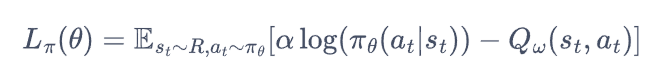

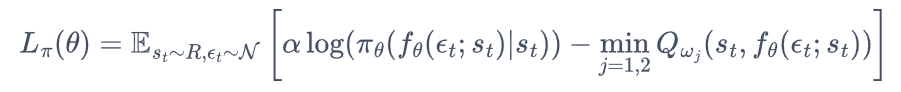

评论员网络还是Q网络, 其更新和之前一样, 采用差分方法, 但是其中价值函数V要加上熵（不知道为什么）, 损失函数如下图

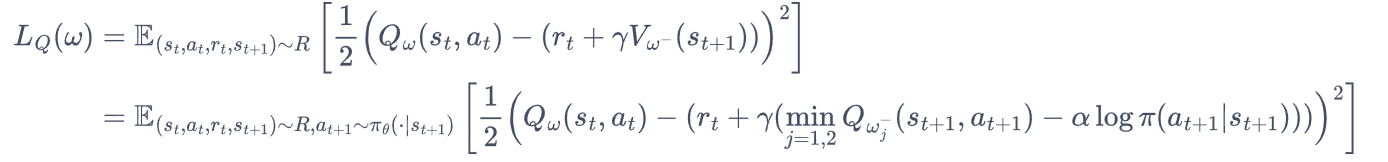

控制熵的重要性的$\alpha$也要更新, 通过如下一图的约束推导出其损失函数, 该约束也就是最大化期望回报, 同时约束熵的均值大于目标熵$H_0$, 目标熵是一个可以控制的参数

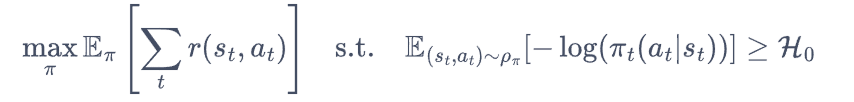

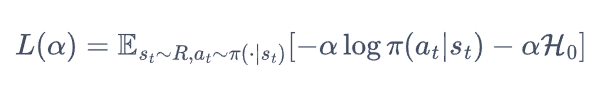

# 初始化参数

In [4]:
# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# SAC算法相关
PATH = 'checkpoints/SAC_PDv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 10
total_episodes = 100
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 神经网络相关
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
hidden_dim = 128

# 其他
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, 
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

cuda


# 检查点函数

In [1]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

## 读取检查点

In [6]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# 训练函数

In [22]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, return_list, PATH, 3)

总耗时: 35分钟


# 作图

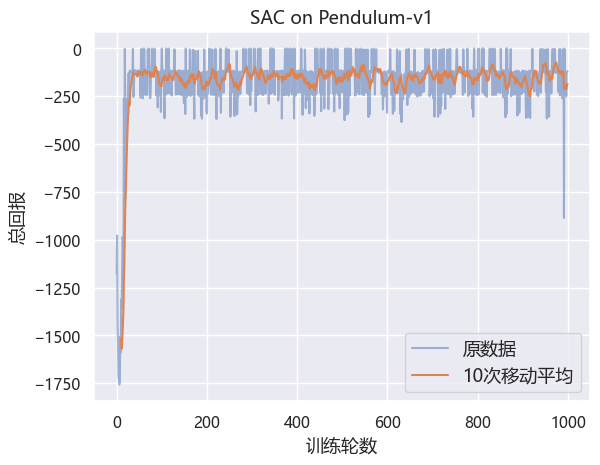

In [7]:
rl_utils.picture_return(return_list, 'SAC', env_name)

# 演示策略

平均回报:  -155.378


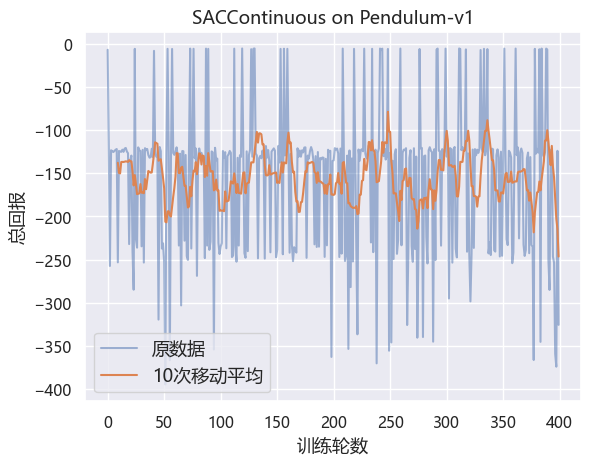

In [23]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=400, model_type='AC', if_return=True)

平均回报:  -157.589


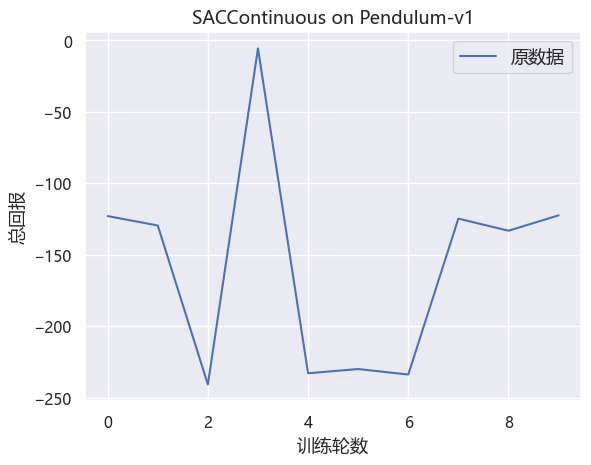

In [7]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)